In [18]:
import pandas as pd
from pathlib import Path

In [19]:
ecg_data_dir = Path('../data/ECGs')

In [20]:
len(list(ecg_data_dir.glob('*.xml')))

43511

In [21]:
xml_file_path = list(ecg_data_dir.glob('*.xml'))[0]

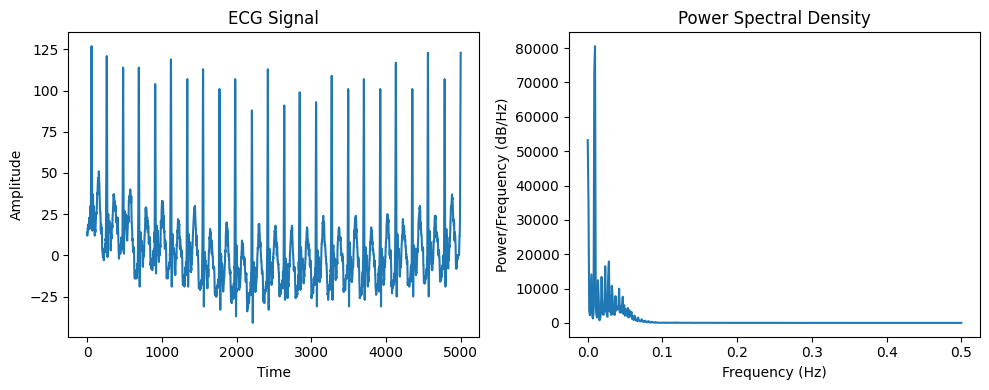

In [32]:
import xmltodict
import base64
import array
import matplotlib.pyplot as plt
import numpy as np
import struct
from matplotlib.mlab import psd

with open(xml_file_path, 'r') as file:
        # Read XML content from the file
        xml_content = file.read()
        # Parse XML to dictionary
        data_dict = xmltodict.parse(xml_content)
        b64 = data_dict['RestingECG']['Waveform'][1]['LeadData'][0]['WaveFormData']
        # print(b64)
        decoded_bytes = base64.b64decode(b64)
        # Assuming the array is of floating-point numbers, use the 'd' type code
        float_array = struct.unpack(f'{len(decoded_bytes)//2}h', decoded_bytes)
        time = np.arange(0, len(float_array), 1)
        
        # Plot the ECG signal
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.plot(time, float_array)
        plt.title('ECG Signal')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')

        # Compute and plot the PSD
        plt.subplot(1, 2, 2)
        power, frequencies = psd(float_array, NFFT=1024, Fs=1)
        # plt.plot(frequencies, 10 * np.log10(power))
        plt.plot(frequencies, power)
        plt.title('Power Spectral Density')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power/Frequency (dB/Hz)')

        plt.tight_layout()
        plt.show()

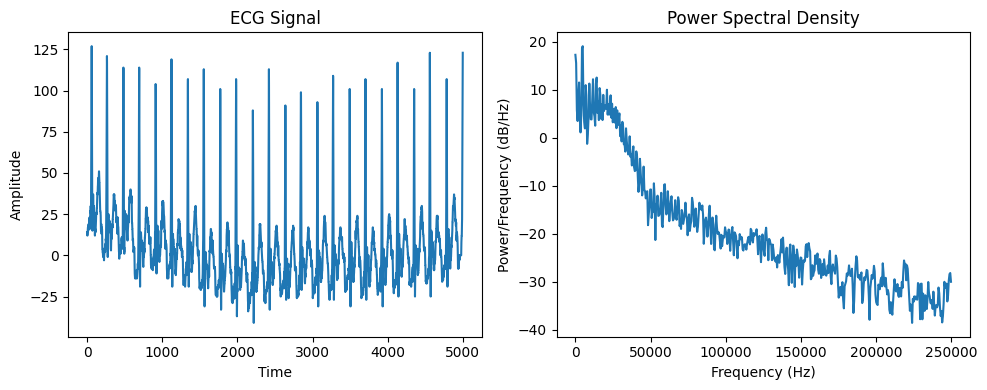

In [24]:
import xmltodict
import base64
import array
import matplotlib.pyplot as plt
import numpy as np
import struct
from matplotlib.mlab import psd

with open(xml_file_path, 'r') as file:
    # Read XML content from the file
    xml_content = file.read()
    # Parse XML to dictionary
    data_dict = xmltodict.parse(xml_content)
    b64 = data_dict['RestingECG']['Waveform'][1]['LeadData'][0]['WaveFormData']
    decoded_bytes = base64.b64decode(b64)
    # Assuming the array is of floating-point numbers, use the 'd' type code
    float_array = struct.unpack(f'{len(decoded_bytes)//2}h', decoded_bytes)
    time = np.arange(0, len(float_array), 1)

    # Plot the ECG signal
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(time, float_array)
    plt.title('ECG Signal')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

    # Compute and plot the PSD
    plt.subplot(1, 2, 2)
    # Specify the correct sampling frequency (Fs)
    Fs = 1000  # Replace 1000 with your actual sampling frequency
    power, frequencies = psd(float_array, NFFT=1024, Fs=Fs)
    plt.plot(frequencies * Fs / 2, 10 * np.log10(power))  # Adjust the frequency axis
    plt.title('Power Spectral Density')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power/Frequency (dB/Hz)')

    plt.tight_layout()
    plt.show()


In [25]:
import xmltodict
import json
import base64
import array
import matplotlib.pyplot as plt
import numpy as np
import struct
from matplotlib.mlab import psd
from biosppy.signals import ecg

xml_file_path = file_path

with open(xml_file_path, 'r') as file:
    # Read XML content from the file
    xml_content = file.read()
    # Parse XML to dictionary
    data_dict = xmltodict.parse(xml_content)
    b64 = data_dict['RestingECG']['Waveform'][1]['LeadData'][0]['WaveFormData']
    # print(b64)
    decoded_bytes = base64.b64decode(b64)
    # Assuming the array is of floating-point numbers, use the 'h' type code
    float_array = np.array(struct.unpack(f'{len(decoded_bytes)//2}h', decoded_bytes))
    time = np.arange(0, len(float_array), 1)

    # Remove baseline wander using biosppy
    order = 3  # Adjust the filter order as needed
    sampling_rate = 1000  # Adjust the sampling rate as needed
    filtered, _, _ = ecg.st.filter_signal(signal=float_array, sampling_rate=sampling_rate, order=order)

    # Plot the original and filtered ECG signal
    plt.figure(figsize=(12, 6))
    
    plt.subplot(2, 2, 1)
    plt.plot(time, float_array)
    plt.title('Original ECG Signal')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

    plt.subplot(2, 2, 2)
    plt.plot(time, filtered)
    plt.title('Filtered ECG Signal (Baseline Wander Removed)')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

    # Compute and plot the PSD for the original signal
    plt.subplot(2, 2, 3)
    power, frequencies = psd(float_array, NFFT=1024, Fs=sampling_rate)
    plt.plot(frequencies, 10 * np.log10(power))
    plt.title('Power Spectral Density (Original Signal)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power/Frequency (dB/Hz)')

    # Compute and plot the PSD for the filtered signal
    plt.subplot(2, 2, 4)
    power, frequencies = psd(filtered, NFFT=1024, Fs=sampling_rate)
    plt.plot(frequencies, 10 * np.log10(power))
    plt.title('Power Spectral Density (Filtered Signal)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power/Frequency (dB/Hz)')

    plt.tight_layout()
    plt.show()

TypeError: Please specify the cutoff frequency.